## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from config import config
import os
import sys
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from flow_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

CPUs are used!


# Problem description

The FER 2013 dataset. We will only train on the expressions Happy, Surprised, and Neutral.

Attained from the following kaggle competition: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
a_prior = config['a_prior']
SAMPLES = 1



#---------DATA------------
df = pd.read_csv("../../../fer2013/icml_face_data.csv")

data = np.zeros((len(df), 48*48))
for i in range(len(data)):
    data[i] = np.array(df[" pixels"][i].split(" ")).astype(np.float32)/255.
targets = df.emotion.values

X_original,y_original  = data, targets
used_inds = [yi in [3,5,6] for yi in y_original]  # Happy, sad and neutral
y_original = y_original[used_inds]
y_original = np.where(y_original == 3, 0, y_original)
y_original = np.where(y_original == 5, 1, y_original)
y_original = np.where(y_original == 6, 2, y_original)
X_original = X_original[used_inds]
n,p = X_original.shape
print(n,p,dim)

n_classes = len(np.unique(y_original))
multiclass = n_classes > 1

BATCH_SIZE = int(n*0.8)
TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int(n*0.80)
TEST_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

19189 2304 50


# Sigmoid based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42, stratify=y_original)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [4]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, num_transforms=num_transforms, a_prior=a_prior, n_classes=n_classes).to(DEVICE)
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem), post_train=post_train, multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni],test_dat,DEVICE,SAMPLES=10, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

network 0
122262
0
loss 1785025.625
nll 16901.2421875
density 0.9832801789099448

val_loss: 1861750.1250, val_nll: 5303.1196, val_ensemble: 0.4565, used_weights_median: 122262

1
loss 1897963.25
nll 41469.21875
density 0.9825118095503182

val_loss: 2162772.5000, val_nll: 397695.4688, val_ensemble: 0.2199, used_weights_median: 122262

2
loss 4919154.5
nll 3154058.0
density 0.9817156564782579

val_loss: 1946911.2500, val_nll: 202804.1250, val_ensemble: 0.3184, used_weights_median: 122262

3
loss 3332992.25
nll 1588847.375
density 0.9808753772660113

val_loss: 1853551.6250, val_nll: 114732.0469, val_ensemble: 0.3184, used_weights_median: 122262

4
loss 2629943.75
nll 891059.75
density 0.9799960525511556

val_loss: 1772028.5000, val_nll: 42443.9688, val_ensemble: 0.3184, used_weights_median: 122262

5
loss 2053847.0
nll 324375.34375
density 0.9790781173195763

val_loss: 1748179.8750, val_nll: 30433.4980, val_ensemble: 0.4617, used_weights_median: 122262

6
loss 1949172.75
nll 231620.109375

## Weights used each class

Classes:
* 0 = Happy
* 1 = Surprised
* 2 = Neutral

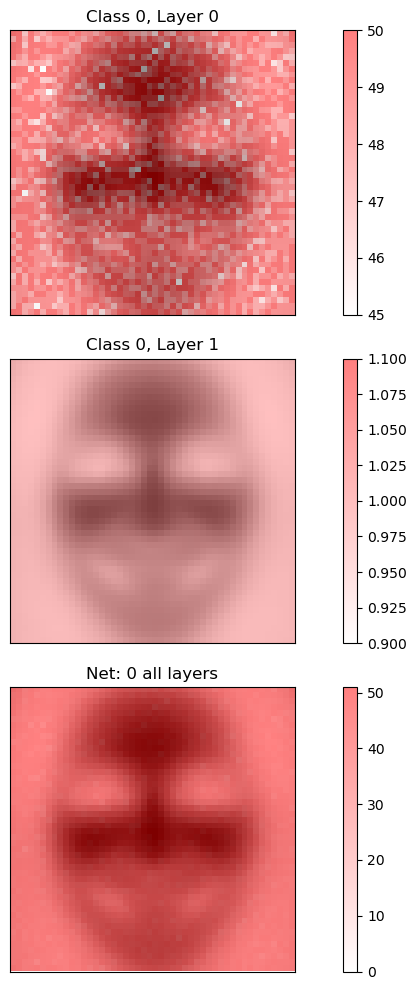

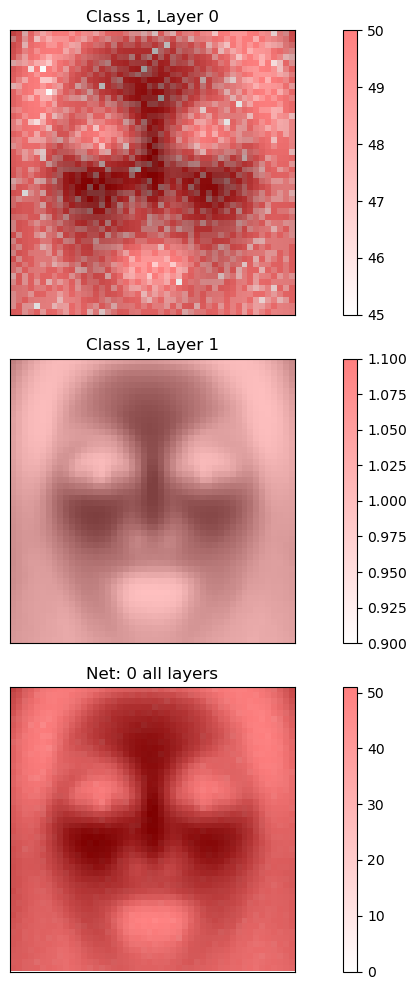

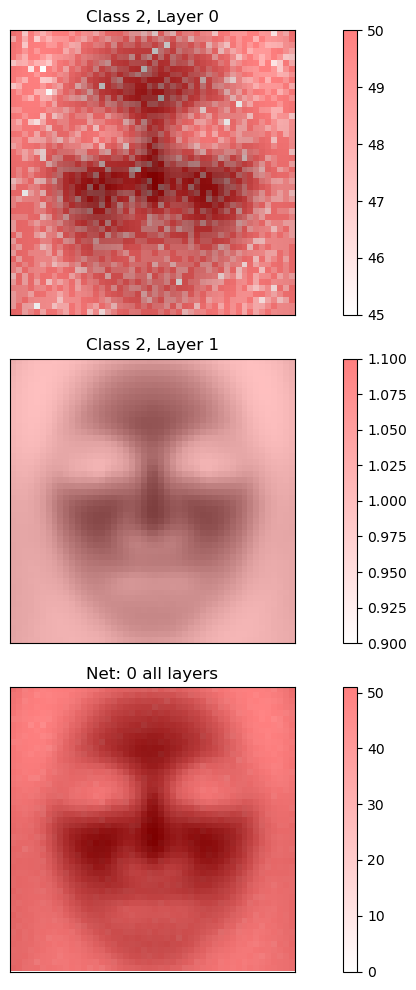

In [5]:
train_data = torch.tensor(copy.deepcopy(X_original),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y_original), dtype=torch.float32)
for c in range(n_classes):
    pf.plot_model_vision_image(net, train_data=train_data, train_target=train_target, c=c, save_path=f"individual_classes/class{c}")

# ReLU based network

## Seperate a test set for later

In [6]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42, stratify=y_original)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [7]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, num_transforms=num_transforms, act_func=F.relu, a_prior=a_prior, n_classes=n_classes).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem), post_train=post_train, multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni],test_dat,DEVICE,SAMPLES=10, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

network 0
122262
0
loss 1785040.625
nll 16916.279296875
density 0.9832801789128699

val_loss: 1869516.8750, val_nll: 16016.4785, val_ensemble: 0.4617, used_weights_median: 122262

1
loss 1971747.0
nll 118242.546875
density 0.982524126314235

val_loss: 2169386.2500, val_nll: 402964.7188, val_ensemble: 0.2199, used_weights_median: 122262

2
loss 4965744.0
nll 3199318.25
density 0.9817664587413468

val_loss: 2063084.7500, val_nll: 321455.3438, val_ensemble: 0.3184, used_weights_median: 122262

3
loss 4220846.0
nll 2479162.75
density 0.9809590200113175

val_loss: 1855741.0000, val_nll: 115639.6250, val_ensemble: 0.3184, used_weights_median: 122262

4
loss 2648998.25
nll 908809.625
density 0.9801272576198973

val_loss: 1781760.5000, val_nll: 50069.3164, val_ensemble: 0.2199, used_weights_median: 122262

5
loss 2097091.75
nll 365519.8125
density 0.9792814950440774

val_loss: 1845662.0000, val_nll: 98848.8359, val_ensemble: 0.4617, used_weights_median: 122262

6
loss 2483946.5
nll 726972.375


## Weights used each class

Classes:

* 0 = Happy
* 1 = Surprised
* 2 = Neutral

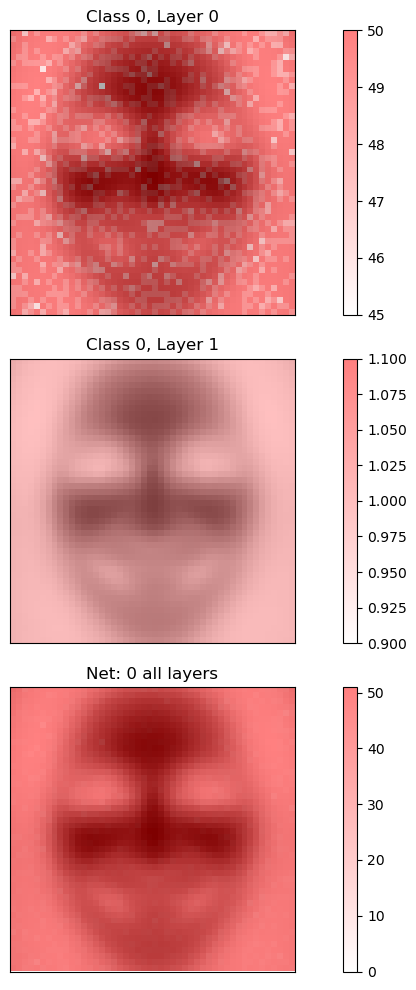

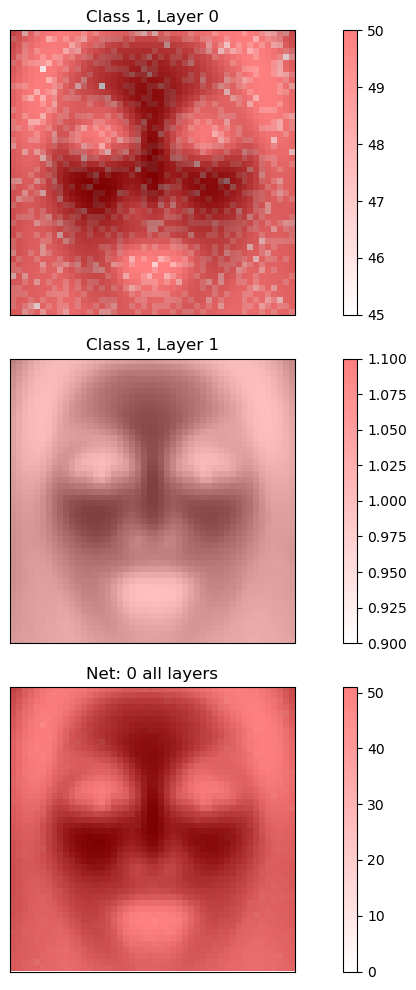

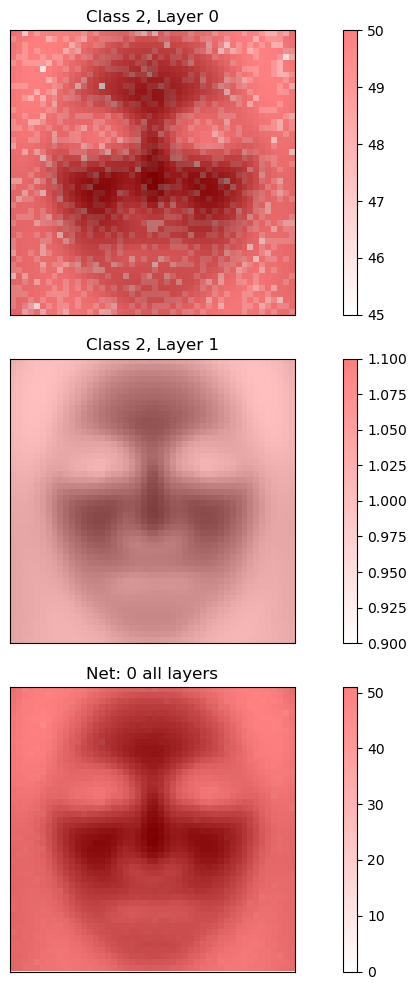

In [8]:
train_data = torch.tensor(copy.deepcopy(X_original),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y_original), dtype=torch.float32)
for c in range(n_classes):
    pf.plot_model_vision_image(net, train_data=train_data, train_target=train_target, c=c, save_path=f"individual_classes/class{c}")